In [1]:
# PL trainer
import pytorch_lightning as pl
from Dataset import __Dataset
from torch.utils.data import DataLoader
from PL_Trainer import Simple_Trainer
from Utils import get_callbacks, init__weighted_random__sampler
import torch
# for stacking part
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import RandomOverSampler
# utils
from Utils import scale_data_without_nan_and_fillna_after
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
from copy import deepcopy
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# metrics
from sklearn.metrics import f1_score, classification_report
# visualization
import matplotlib.pyplot as plt
# for clustering features part
import category_encoders as ce
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
# visualize
%matplotlib inline

In [2]:
def del_bad_columns(df_transaction, df_identity):
    # V107 удаляем, там нет дисперсии (одно значение везде)
    del df_transaction['V107']
    del df_identity['id_27']
    del df_identity['id_23']
    del df_identity['id_10'] # нет дисперсии (один вид значения)
    ## drop cols with > 70% gaps
    df_transaction.drop(missing_value_df_transaction.index[-168:].values.tolist(), axis=1, inplace=True)
    ## drop cols with > 70% gaps
    df_identity.drop(missing_value_df_identity.index[-7:].values.tolist(), axis=1, inplace=True)
    
    
def del_skewness_curtosis_in_columns(df_identity):
    df_identity['id_01'] = df_identity['id_01'].apply(np.sqrt)
    df_identity['id_02'] = df_identity['id_02'].apply(np.sqrt)
    df_identity['id_17'] = df_identity['id_17'].apply(np.log10)
    df_identity['id_18'] = df_identity['id_18'].apply(np.log10)

In [3]:
df_identity = pd.read_csv('train_identity.csv')
df_transaction = pd.read_csv('train_transaction.csv')

df_identity_test = pd.read_csv('test_identity.csv')
df_transaction_test = pd.read_csv('test_transaction.csv')

## test column names need to change
df_identity_test.columns = [x.replace('-', '_') for x in df_identity_test.columns]

### Identity

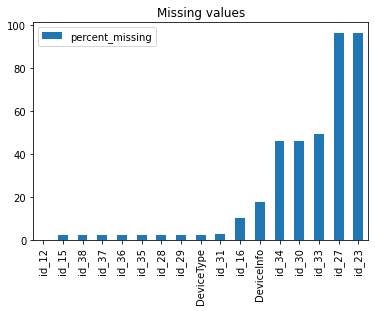

In [4]:
categorical_cols_identity = df_identity.select_dtypes(include=['category', 'object']).columns.tolist()
# check missing
percent_missing = df_identity[categorical_cols_identity].isnull().sum() * 100 / len(df_identity[categorical_cols_identity])
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.iloc[:].plot.bar(title='Missing values')
categorical_cols_identity + ['id_01', 'id_03', 'id_04', 'id_09', 'id_14', 'id_32', 'TransactionID']
## gap filling
for col in categorical_cols_identity: ## + id_32
    df_identity[col] = df_identity[col].fillna('No Information')
    df_identity_test[col] = df_identity_test[col].fillna('No Information')

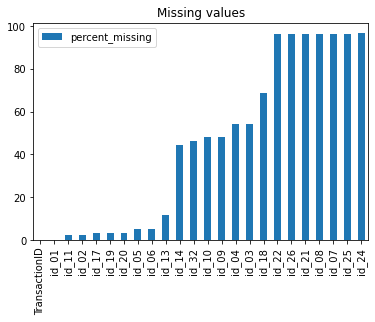

In [5]:
num_cols_identity = df_identity._get_numeric_data().columns
percent_missing = df_identity[num_cols_identity].isnull().sum() * 100 / len(df_identity[num_cols_identity])
missing_value_df_identity = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df_identity.sort_values('percent_missing', inplace=True)
missing_value_df_identity.iloc[:].plot.bar(title='Missing values')
## only continuous
num_cols_identity = ['id_20', 'id_19', 'id_18', 'id_17', 'id_13', 'id_11', 'id_06', 'id_05', 'id_02']

### Transaction

In [6]:
percent_missing = df_transaction.isnull().sum() * 100 / len(df_transaction)
missing_value_df_transaction = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df_transaction.sort_values('percent_missing', inplace=True)
print(missing_value_df_transaction[-168:])

       percent_missing
V238         76.053104
V220         76.053104
V221         76.053104
V222         76.053104
V227         76.053104
...                ...
D12          89.041047
D14          89.469469
D13          89.509263
D7           93.409930
dist2        93.628374

[168 rows x 1 columns]


In [7]:
del_bad_columns(df_transaction, df_identity)
del_bad_columns(df_transaction_test, df_identity_test)
## identity categorical cols for modelling
categorical_cols_identity = df_identity.select_dtypes(include=['category', 'object']).columns.tolist()
categorical_cols_identity + ['id_01', 'id_03', 'id_04', 'id_09', 'id_14', 'id_32', 'TransactionID']

['id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'id_01',
 'id_03',
 'id_04',
 'id_09',
 'id_14',
 'id_32',
 'TransactionID']

In [8]:
categorical_cols_transaction = [
    'ProductCD', 'card4', 'card6', 'card2', 'card3', 'card5', 'P_emaildomain',
    'addr1', 'addr2', 'card1', 'V1', 
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
    'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9','V10', 
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 
    'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
    'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 
    'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 
    'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 
    'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58',
    'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66',
    'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 
    'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 
    'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 
    'V91', 'V92', 'V93', 'V94', 'V281', 'V282', 'V283', 'V284',
    'V286', 'V287', 'V288', 'V289', 'V297', 'V299', 'V300',
    'V301', 'V302', 'V303', 'V304', 'V305', 'V98', 'V106', 
    'V108','V109','V110','V111','V112', 'V113','V114',
    'V115','V116','V117','V118', 'V119','V120','V121', 
    'V122','V123','V124', 'V125', 'V99', 'V104', 'V100', 'V105' 
]

## fillna train / test
for col in categorical_cols_transaction:
    df_transaction[col] = df_transaction[col].fillna('No Information') 
    df_transaction_test[col] = df_transaction_test[col].fillna('No Information') 
## 
categorical_col__unique_values = {}
for col in categorical_cols_transaction:
    categorical_col__unique_values[col] = df_transaction[col].unique()
##
num_cols_transaction = [
    'TransactionAmt','dist1', 'V95', 'V96', 'V97', 'V101', 'V102', 'V103', 
    'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134',
    'V135', 'V136', 'V137', 'V279', 'V280', 'V285', 'V290', 'V291', 'V292', 
    'V293', 'V294', 'V295', 'V296', 'V298', 'V306', 'V307', 'V308', 'V309', 
    'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 
    'V319', 'V320', 'V321', 'C1','C2','C4','C5','C6','C7', 'C8','C9','C10',
    'C11', 'C3', 'C12','C13','C14','D1', 'D2','D3','D4','D5', 'D10', 'D11', 'D15'
]

In [9]:
### remove skewness / curtosis 
del_skewness_curtosis_in_columns(df_identity)
del_skewness_curtosis_in_columns(df_identity_test)

In [10]:
percent_missing = df_identity[num_cols_identity].isnull().sum() * 100 / len(df_identity[num_cols_identity])
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
print(missing_value_df)

       percent_missing
id_11         2.256765
id_02         2.330257
id_17         3.372321
id_19         3.407681
id_20         3.447200
id_06         5.108401
id_05         5.108401
id_13        11.726165
id_18        68.722137


In [11]:
# Identity
## train
numerical_col_identity__minmaxscaler = scale_data_without_nan_and_fillna_after(df_identity, num_cols_identity)
df_identity = df_identity.fillna(-1)
## test
scale_data_without_nan_and_fillna_after(df_identity_test, num_cols_identity, numerical_col_identity__minmaxscaler)
df_identity_test = df_identity_test.fillna(-1)

# Transaction
## train
numerical_col_transaction__minmaxscaler = scale_data_without_nan_and_fillna_after(df_transaction, num_cols_transaction)
df_transaction = df_transaction.fillna(-1)
## test
scale_data_without_nan_and_fillna_after(df_transaction_test, num_cols_transaction, numerical_col_transaction__minmaxscaler)
df_transaction_test = df_transaction_test.fillna(-1)

In [12]:
# TRAIN
## merge and gap filling
df_train = df_transaction.merge(df_identity, how='left', on='TransactionID')
for col in categorical_cols_transaction + categorical_cols_identity:
    df_train[col] = df_train[col].fillna('No Information')
df_train[num_cols_transaction + num_cols_identity] = df_train[num_cols_transaction + num_cols_identity].fillna(-1)
Y = df_train['isFraud']
# TEST
df_prod = df_transaction_test.merge(df_identity_test, how='left', on='TransactionID')
for col in categorical_cols_transaction + categorical_cols_identity:
    df_prod[col] = df_prod[col].fillna('No Information')
df_prod[num_cols_transaction + num_cols_identity] = df_prod[num_cols_transaction + num_cols_identity].fillna(-1)
## Full
df_train = df_train[num_cols_transaction + num_cols_identity + categorical_cols_transaction + categorical_cols_identity]

In [13]:
## Add clustering features
## catboostencoder for categorical
## fit df_train, predict df_prod 

cb_encoder = ce.CatBoostEncoder()
data_for_clustering = deepcopy(df_train)
data_for_clustering_prod = deepcopy(df_prod)

for col in categorical_cols_transaction + categorical_cols_identity:
    data_for_clustering[col] = data_for_clustering[col].astype(str)
    data_for_clustering_prod[col] = data_for_clustering_prod[col].astype(str)

## catboost encoder after label encoding
data_for_clustering[categorical_cols_transaction + categorical_cols_identity] = cb_encoder.fit_transform(data_for_clustering[categorical_cols_transaction + categorical_cols_identity], Y)
data_for_clustering_prod[categorical_cols_transaction + categorical_cols_identity] = cb_encoder.transform(data_for_clustering_prod[categorical_cols_transaction + categorical_cols_identity])

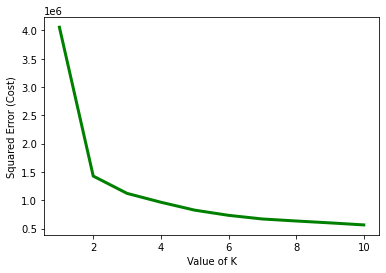

In [14]:
## find the optimal number of clusters
cost = []
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 1500)
    KM.fit(data_for_clustering)
    cost.append(KM.inertia_)    
    
# plot the cost against K values
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot

In [15]:
# I will add an additional feature - the distance to the center of the cluster
## used distances: euclidean, manhattan, chebyshev

kmeans = KMeans(n_clusters = 3, max_iter = 1500)
identified_clusters = kmeans.fit_predict(data_for_clustering)
## prod
identified_clusters_prod = kmeans.predict(data_for_clustering_prod[data_for_clustering.columns])

##
cluster_centers = kmeans.cluster_centers_
scaler_euclidean = MinMaxScaler()
euclidean = cdist(data_for_clustering.values, cluster_centers, 'euclidean')
euclidean = scaler_euclidean.fit_transform(euclidean)
## prod
euclidean_prod = cdist(data_for_clustering_prod[data_for_clustering.columns].values, cluster_centers, 'euclidean')
euclidean_prod = scaler_euclidean.transform(euclidean_prod)

##
scaler_manhattan = MinMaxScaler()
manhattan = cdist(data_for_clustering.values, cluster_centers, 'cityblock')
manhattan = scaler_manhattan.fit_transform(manhattan)
## prod
manhattan_prod = cdist(data_for_clustering_prod[data_for_clustering.columns].values, cluster_centers, 'cityblock')
manhattan_prod = scaler_manhattan.transform(manhattan_prod)

##
scaler_chebyshev = MinMaxScaler()
chebyshev = cdist(data_for_clustering.values, cluster_centers, 'chebyshev')
chebyshev = scaler_chebyshev.fit_transform(chebyshev)
## prod
chebyshev_prod = cdist(data_for_clustering_prod[data_for_clustering.columns].values, cluster_centers, 'chebyshev')
chebyshev_prod = scaler_chebyshev.transform(chebyshev_prod)

## 
df_train[['euclidean_1', 'euclidean_2', 'euclidean_3']] = euclidean
df_train[['manhattan_1', 'manhattan_2', 'manhattan_3']] = manhattan
df_train[['chebyshev_1', 'chebyshev_2', 'chebyshev_3']] = chebyshev
##
df_prod[['euclidean_1', 'euclidean_2', 'euclidean_3']] = euclidean_prod
df_prod[['manhattan_1', 'manhattan_2', 'manhattan_3']] = manhattan_prod
df_prod[['chebyshev_1', 'chebyshev_2', 'chebyshev_3']] = chebyshev_prod
##
clustering_cols = ['euclidean_1', 'euclidean_2', 'euclidean_3', 'manhattan_1', 'manhattan_2', 'manhattan_3', 'chebyshev_1', 'chebyshev_2', 'chebyshev_3']

In [16]:
## Split -> Encode
X_train, X_val, Y_train, Y_val = train_test_split(df_train, Y, stratify=Y, train_size=0.75, random_state=27)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, stratify=Y_val, train_size=0.75, random_state=27)
###
col__labelEncoder = {}
for col in tqdm(categorical_cols_transaction + categorical_cols_identity):
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    df_prod[col] = df_prod[col].astype(str)
    ###
    le = LabelEncoder()
    le.fit(X_train[col].values)
    le.classes_ = np.append(le.classes_, '<unknown>')
    X_train[col] = le.transform(X_train[col])
    ## if there are unknown labels -> unknown category
    X_val[col] = X_val[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    X_val[col] = le.transform(X_val[col])
    ## test
    X_test[col] = X_test[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    X_test[col] = le.transform(X_test[col])
    ## prod
    df_prod[col] = df_prod[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    df_prod[col] = le.transform(df_prod[col])
    col__labelEncoder[col] = le

  0%|          | 0/168 [00:00<?, ?it/s]/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
100%|██████████| 168/168 [12:57<00:00,  4.63s/it] 


In [17]:
## train -> train_main, train_stacking
## 15% for val_stacking
X_train, X_train_stacking, Y_train, Y_train_stacking = train_test_split(X_train, Y_train, stratify=Y_train, train_size=0.75, random_state=27)
X_train_stacking, X_val_stacking, Y_train_stacking, Y_val_stacking = train_test_split(X_train_stacking, Y_train_stacking, stratify=Y_train_stacking, train_size=0.85, random_state=27)
X_stacking_train_over, Y_stacking_train_over = RandomOverSampler(random_state=0).fit_resample(X_train_stacking, Y_train_stacking) 

In [18]:
xgb_oversampled = XGBClassifier(eta=0.001, max_depth=12, tree_method='approx') # 'approx'
xgb_oversampled.fit(X_stacking_train_over, Y_stacking_train_over)
preds = xgb_oversampled.predict(X_val_stacking.values)
print(classification_report(preds, Y_val_stacking))

##
xgb_standard = XGBClassifier(eta=0.001, max_depth=9, tree_method='approx') # 'approx'
xgb_standard.fit(X_train_stacking, Y_train_stacking)
preds = xgb_standard.predict(X_val_stacking.values)
print(classification_report(preds, Y_val_stacking))

##
tab_net_classifier_1 = TabNetClassifier(n_d=512, n_a=512)
tab_net_classifier_1.fit(
  X_stacking_train_over.values, Y_stacking_train_over.values,
  eval_set=[(X_val_stacking.values, Y_val_stacking.values)], max_epochs=100
)
preds = tab_net_classifier_1.predict(X_val_stacking.values)
print(classification_report(preds, Y_val_stacking))

##
tab_net_classifier_2 = TabNetClassifier(n_d=256, n_a=256)
tab_net_classifier_2.fit(
  X_stacking_train_over.values, Y_stacking_train_over.values,
  eval_set=[(X_val_stacking.values, Y_val_stacking.values)], max_epochs=100
)
preds = tab_net_classifier_2.predict(X_val_stacking.values)
print(classification_report(preds, Y_val_stacking))

/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     14655
           1       0.63      0.19      0.29      1955

    accuracy                           0.89     16610
   macro avg       0.76      0.59      0.61     16610
weighted avg       0.87      0.89      0.86     16610



/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     16383
           1       0.29      0.75      0.42       227

    accuracy                           0.97     16610
   macro avg       0.64      0.86      0.70     16610
weighted avg       0.99      0.97      0.98     16610

Device used : cuda
epoch 0  | loss: 0.74144 | val_0_auc: 0.78221 |  0:00:07s
epoch 1  | loss: 0.44904 | val_0_auc: 0.81451 |  0:00:15s
epoch 2  | loss: 0.39688 | val_0_auc: 0.83186 |  0:00:22s
epoch 3  | loss: 0.33486 | val_0_auc: 0.85734 |  0:00:29s
epoch 4  | loss: 0.28174 | val_0_auc: 0.83291 |  0:00:37s
epoch 5  | loss: 0.23735 | val_0_auc: 0.80662 |  0:00:44s
epoch 6  | loss: 0.20869 | val_0_auc: 0.84304 |  0:00:

In [19]:
def predict_proba_from_models(model, data):
    return model.predict_proba(data)[:, 1]

train_probas = []
for idx, model in enumerate([xgb_oversampled, xgb_standard, tab_net_classifier_1, tab_net_classifier_2]):
    probas_list = predict_proba_from_models(model, X_train.values)
    train_probas.append(probas_list)

val_probas = []
for idx, model in enumerate([xgb_oversampled, xgb_standard, tab_net_classifier_1, tab_net_classifier_2]):
    probas_list = predict_proba_from_models(model, X_val.values)
    val_probas.append(probas_list)

test_probas = []
for idx, model in enumerate([xgb_oversampled, xgb_standard, tab_net_classifier_1, tab_net_classifier_2]):
    probas_list = predict_proba_from_models(model, X_test.values)
    test_probas.append(probas_list)

prod_probas = []
for idx, model in enumerate([xgb_oversampled, xgb_standard, tab_net_classifier_1, tab_net_classifier_2]):
    probas_list = predict_proba_from_models(model, df_prod[df_train.columns].values)
    prod_probas.append(probas_list)

for idx, probas_lst in enumerate(train_probas):
    X_train['predict_proba_from_model__' + str(idx)] = probas_lst
    
for idx, probas_lst in enumerate(val_probas):
    X_val['predict_proba_from_model__' + str(idx)] = probas_lst
    
for idx, probas_lst in enumerate(test_probas):
    X_test['predict_proba_from_model__' + str(idx)] = probas_lst
    
for idx, probas_lst in enumerate(prod_probas):
    df_prod['predict_proba_from_model__' + str(idx)] = probas_lst

In [20]:
# Define categorical column indexes, numeric column indices
MAX_EMBEDDING_DIM = 100
cat_dim = [int(df_train[col].nunique()) + 1 for col in categorical_cols_transaction + categorical_cols_identity] ## I add +1 because in prod there are unknown labels
cat_dim = [[x, min(MAX_EMBEDDING_DIM, (x + 1) // 2)] for x in cat_dim]
for el in cat_dim:
    if el[0] < 10:
        el[1] = el[0]
###
cat_cols_idx, cont_cols_idx = list(), list()
for idx, column in enumerate(X_train.columns):
    if column in categorical_cols_transaction + categorical_cols_identity:
        cat_cols_idx.append(idx)
    else:
        cont_cols_idx.append(idx)

In [21]:
train_dataset = __Dataset(X_train.values, targets=Y_train.values, is_train=True, cat_cols_idx=cat_cols_idx, cont_cols_idx=cont_cols_idx)
val_dataset = __Dataset(X_val.values, targets=Y_val.values, is_train=True, cat_cols_idx=cat_cols_idx, cont_cols_idx=cont_cols_idx)
test_dataset = __Dataset(X_test.values, targets=Y_test.values, is_train=True, cat_cols_idx=cat_cols_idx, cont_cols_idx=cont_cols_idx)
train__weighted_random_sampler = init__weighted_random__sampler(Y_train) ## we will use this sampler for balancing

train_dl = DataLoader(train_dataset,
                      sampler=train__weighted_random_sampler,
                      batch_size=2048,
                      num_workers=20)
val_dl = DataLoader(val_dataset,
                      shuffle=False,
                      batch_size=2048,
                      num_workers=20)
test_dl = DataLoader(test_dataset,
                      shuffle=False,
                      batch_size=2048,
                      num_workers=20)

In [22]:
callbacks, checkpoint_callback = get_callbacks()
model = Simple_Trainer(cat_dim,
                       X_train.columns[cont_cols_idx].values.tolist(),
                       learning_rate=1e-4
                      )

trainer = pl.Trainer(
        gpus=[0, 1],
        accelerator='dp',
        callbacks=[callbacks, checkpoint_callback],
        gradient_clip_val=0.2,
        precision=32,  # 32 for reproducibility, 16 for test
        auto_lr_find=True,
        max_epochs=100,
        checkpoint_callback=True)
trainer.fit(model, train_dl, val_dl)
##
checkpoint = torch.load(checkpoint_callback.best_model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])

/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:282: LightningDeprecationWarning: Passing `Trainer(accelerator='dp')` has been deprecated in v1.5 and will be removed in v1.7. Use `Trainer(strategy='dp')` instead.
  f"Passing `Trainer(accelerator={self.distributed_backend!r})` has been deprecated"
/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:143: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type                 | Params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch     8: reducing learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    15: reducing learning rate of group 0 to 2.5000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    17: reducing learning rate of group 0 to 1.2500e-05.


Validating: 0it [00:00, ?it/s]

<All keys matched successfully>

In [24]:
# inference part
model.eval()
model.to('cpu')
yhats = []
real = []
x_test = []
for batch in tqdm(val_dl):
    x, y = batch['data'], batch['target']
    x_test.extend(x)
    y = y.unsqueeze(1)
    yhat = model(x)
    yhats.extend(yhat.flatten().tolist())
    real.extend(y.flatten().tolist())

100%|██████████| 55/55 [00:03<00:00, 17.42it/s]


In [25]:
for thresh in np.linspace(0,1,100):
    yhats_after_thresh = [1 if x > thresh else 0 for x in yhats]
    print('threshold: ', thresh)
    print(classification_report(real, yhats_after_thresh))
    print()

threshold:  0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    106852
           1       0.03      1.00      0.07      3874

    accuracy                           0.03    110726
   macro avg       0.02      0.50      0.03    110726
weighted avg       0.00      0.03      0.00    110726


threshold:  0.010101010101010102
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    106852
           1       0.20      0.83      0.32      3874

    accuracy                           0.88    110726
   macro avg       0.59      0.85      0.62    110726
weighted avg       0.97      0.88      0.91    110726




/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

threshold:  0.020202020202020204
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    106852
           1       0.22      0.81      0.34      3874

    accuracy                           0.89    110726
   macro avg       0.60      0.85      0.64    110726
weighted avg       0.97      0.89      0.92    110726


threshold:  0.030303030303030304
              precision    recall  f1-score   support

           0       0.99      0.90      0.95    106852
           1       0.23      0.80      0.36      3874

    accuracy                           0.90    110726
   macro avg       0.61      0.85      0.65    110726
weighted avg       0.97      0.90      0.93    110726


threshold:  0.04040404040404041
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    106852
           1       0.24      0.79      0.37      3874

    accuracy                           0.91    110726
   macro avg       0.62     

/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/Summarization_Trainer/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### data for submission

In [26]:
prod_dataset = __Dataset(df_prod[X_train.columns].values, targets=None, is_train=False, cat_cols_idx=cat_cols_idx, cont_cols_idx=cont_cols_idx)
test_dl = DataLoader(prod_dataset,
                      shuffle=False,
                      batch_size=512,
                      num_workers=1)

In [27]:
X_test.shape

(36909, 259)

In [28]:
yhats_prod = []
for batch in test_dl:
    x = batch['data'] 
    yhat = model(x)
    yhats_prod.extend(yhat.flatten().tolist())

In [29]:
df_submission = pd.DataFrame({
    'TransactionID': df_prod['TransactionID'].values.tolist(),
    'isFraud': yhats_prod
})

In [30]:
df_submission.to_csv('my_submission.csv', index=False)